# Homework 2

Your task in this lab is to set up and train a neural network on any dataset of your choosing.   Look at UCI ML Repo and Kaggle to find datasets, for example.  

Train a neural network on the dataset without any regularization or other special techniques to get a baseline train and test error.  Then see how much you can improve the network's test error through techniques learned in class like regularization, different optimizers, batch normalization, etc.

In [49]:
from ucimlrepo import fetch_ucirepo 
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

In [50]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure y_train and y_test are Series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Standardize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(y_train.unique()))}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

In [51]:
# Data Loader
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Base NN with no Regularization, Dropout, Batch Normalization
class BaseNN(nn.Module):
    def __init__(self):
        super(BaseNN, self).__init__()
        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# NN with Regularization
class RegularizedNN(nn.Module):
    def __init__(self):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()
        # add dropout layers
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.softmax(x)

# NN with Batch Normalization
class BatchNormNN(nn.Module):
    def __init__(self):
        super(BatchNormNN, self).__init__()
        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return self.softmax(x)
    
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), correct / total

def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=100):
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.4f}')
    print()
    return train_losses, test_losses, test_accuracies

In [52]:
# Training the models:

base_nn = BaseNN()
regularized_nn = RegularizedNN()
batch_norm_nn = BatchNormNN()

criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_nn.parameters(), lr=0.001)
regularized_optimizer = optim.Adam(regularized_nn.parameters(), lr=0.001)
batch_norm_optimizer = optim.Adam(batch_norm_nn.parameters(), lr=0.001)
batch_norm_sgd_optimizer = optim.SGD(batch_norm_nn.parameters(), lr=0.001, weight_decay=0.01, momentum=0.9)

base_train_losses, base_test_losses, base_test_accuracies = train_model(base_nn, train_loader, test_loader, base_optimizer, criterion)
regularized_train_losses, regularized_test_losses, regularized_test_accuracies = train_model(regularized_nn, train_loader, test_loader, regularized_optimizer, criterion)
batch_norm_train_losses, batch_norm_test_losses, batch_norm_test_accuracies = train_model(batch_norm_nn, train_loader, test_loader, batch_norm_optimizer, criterion)
batch_norm_sgd_train_losses, batch_norm_sgd_test_losses, batch_norm_sgd_test_accuracies = train_model(batch_norm_nn, train_loader, test_loader, batch_norm_sgd_optimizer, criterion)

Epoch 1/100 Train Loss: 1.7279 Test Loss: 1.6477 Test Accuracy: 0.5177
Epoch 2/100 Train Loss: 1.6370 Test Loss: 1.6418 Test Accuracy: 0.5246
Epoch 3/100 Train Loss: 1.6256 Test Loss: 1.6308 Test Accuracy: 0.5238
Epoch 4/100 Train Loss: 1.6215 Test Loss: 1.6292 Test Accuracy: 0.5315
Epoch 5/100 Train Loss: 1.6151 Test Loss: 1.6331 Test Accuracy: 0.5315
Epoch 6/100 Train Loss: 1.6144 Test Loss: 1.6282 Test Accuracy: 0.5338
Epoch 7/100 Train Loss: 1.6111 Test Loss: 1.6255 Test Accuracy: 0.5385
Epoch 8/100 Train Loss: 1.6094 Test Loss: 1.6243 Test Accuracy: 0.5392
Epoch 9/100 Train Loss: 1.6069 Test Loss: 1.6297 Test Accuracy: 0.5385
Epoch 10/100 Train Loss: 1.6076 Test Loss: 1.6317 Test Accuracy: 0.5331
Epoch 11/100 Train Loss: 1.6017 Test Loss: 1.6209 Test Accuracy: 0.5415
Epoch 12/100 Train Loss: 1.6022 Test Loss: 1.6307 Test Accuracy: 0.5292
Epoch 13/100 Train Loss: 1.6002 Test Loss: 1.6188 Test Accuracy: 0.5485
Epoch 14/100 Train Loss: 1.6015 Test Loss: 1.6202 Test Accuracy: 0.5431
E


Base NN Test Loss: 1.6126742450202383 Test Accuracy: 0.5492307692307692
Regularized NN Test Loss: 1.622070434616833 Test Accuracy: 0.5423076923076923
Batch Normalization NN Test Loss: 1.597935883010306 Test Accuracy: 0.5623076923076923
Batch Normalization SGD NN Test Loss: 1.6241232214904413 Test Accuracy: 0.5515384615384615



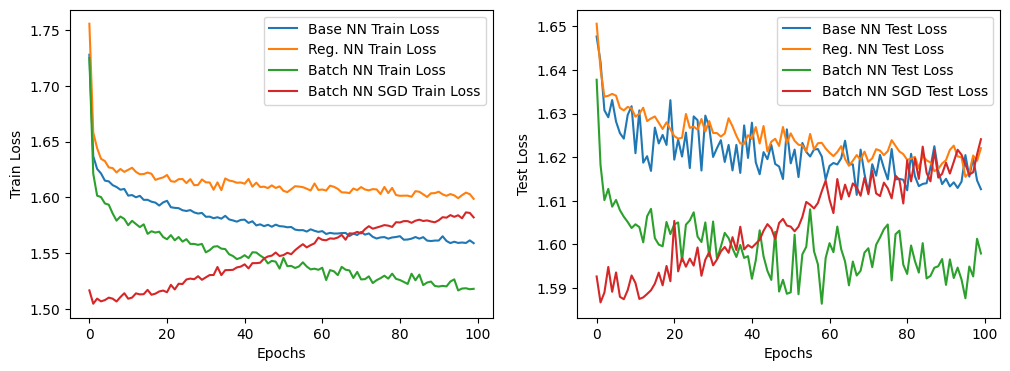

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(base_train_losses, label='Base NN Train Loss')
plt.plot(regularized_train_losses, label='Reg. NN Train Loss')
plt.plot(batch_norm_train_losses, label='Batch NN Train Loss')
plt.plot(batch_norm_sgd_train_losses, label='Batch NN SGD Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(base_test_losses, label='Base NN Test Loss')
plt.plot(regularized_test_losses, label='Reg. NN Test Loss')
plt.plot(batch_norm_test_losses, label='Batch NN Test Loss')
plt.plot(batch_norm_sgd_test_losses, label='Batch NN SGD Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()

# Print the test loss and accuracy for the base, regularized, and batch normalization models
print()
print('Base NN Test Loss:', base_test_losses[-1], 'Test Accuracy:', base_test_accuracies[-1])
print('Regularized NN Test Loss:', regularized_test_losses[-1], 'Test Accuracy:', regularized_test_accuracies[-1])
print('Batch Normalization NN Test Loss:', batch_norm_test_losses[-1], 'Test Accuracy:', batch_norm_test_accuracies[-1])
print('Batch Normalization SGD NN Test Loss:', batch_norm_sgd_test_losses[-1], 'Test Accuracy:', batch_norm_sgd_test_accuracies[-1])
print()

From these values and from the graphs, trying batch normalization with a different optimizers gives minimally better results as the test error is just a bit better than the baseline. For accuracy, the best model would be the one with batch normalization and Adam optimizer.